# Album Investigations

In [5]:
album_name = "piñata".lower()
album_frame = scrobbles[scrobbles["album"].str.lower() == album_name]# FILTER SCROBBLES
album_frame = album_frame.sort_index(ascending=False) # SORT
# album_frame = album_frame.loc[:, descriptor_headers] # DESCRIPTORS

total_time = album_frame["duration_ms"].sum() / (1000 * 60) # minutes
total_days = total_time / (60 * 24) # days
print(f'{album_frame.count()[0]:,d} scrobbles')
print(f'{total_days:.0f} days spent listening since Nov. 2017')
print(f'{total_time / days_since(first_day).days:.2f} minutes/day')

album_frame.describe()[1:]

437 scrobbles
1 days spent listening since Nov. 2017
1.32 minutes/day


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
mean,0.235808,0.514851,209165.501144,0.700108,0.000498,5.306636,0.400828,-8.853126,0.560641,0.318519,109.820730,3.981693,0.499444
std,0.210592,0.085053,68305.827980,0.090924,0.001615,4.180808,0.196045,1.101856,0.496878,0.126598,34.338501,0.134211,0.188996
min,0.010700,0.388000,48507.000000,0.494000,0.000000,0.000000,0.123000,-11.561000,0.000000,0.089200,81.302000,3.000000,0.167000
25%,0.049700,0.427000,183320.000000,0.604000,0.000000,1.000000,0.161000,-9.636000,0.000000,0.203000,89.060000,4.000000,0.391000
50%,0.180000,0.528000,211187.000000,0.715000,0.000000,4.000000,0.389000,-8.561000,1.000000,0.321000,91.546000,4.000000,0.494000
75%,0.261000,0.588000,226520.000000,0.790000,0.000277,11.000000,0.624000,-8.336000,1.000000,0.420000,118.965000,4.000000,0.628000
max,0.904000,0.676000,513707.000000,0.821000,0.008230,11.000000,0.796000,-5.834000,1.000000,0.549000,180.392000,4.000000,0.879000


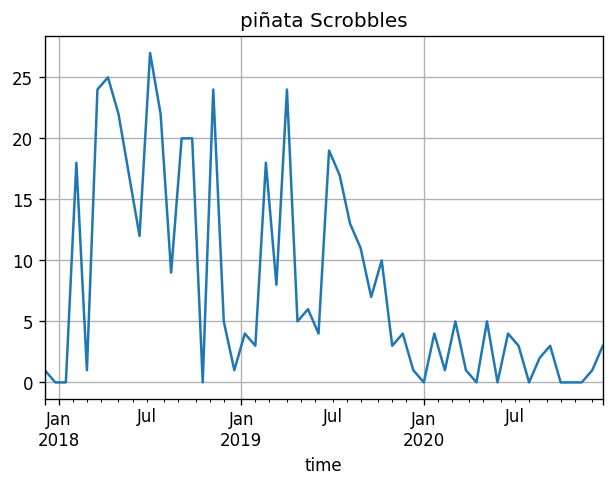

In [6]:
filtered_album = scrobbles[scrobbles["album"].str.lower() == album_name]
# resample by day and mean
filtered_album = filtered_album.resample("3W").count()

filtered_album["energy"].plot()

plt.title(f"{album_name} Scrobbles")
plt.grid()
plt.show()

## Average Descriptor

Below presents the average descriptor for the album. "*All Listened Tracks*" describes the descriptor based on the listening activity for this album. This takes into account how many times a track is listened to. "*Distinct Tracks*" takes only the distinct set of tracks that have been listened to and takes that average.

The difference between them could be described as which features are preferred for an album. If the blue bar is higher than the red, it would indicate that tracks from this album which have a higher value for this are listened to more. 

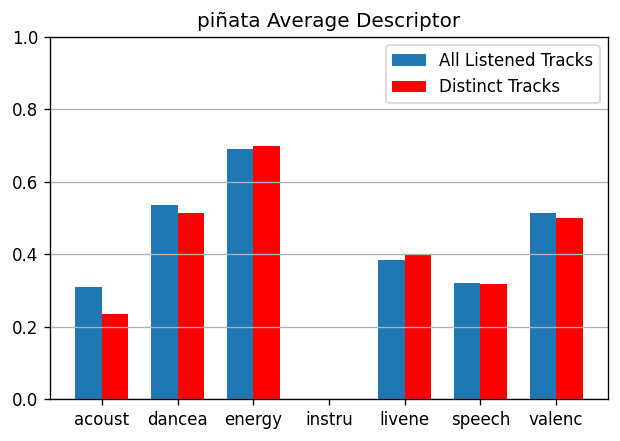

In [7]:
filtered_album = scrobbles[scrobbles["album"].str.lower() == album_name]
filtered_album_no_dup = filtered_album.drop_duplicates(['uri'])

filtered_album_no_dup = filtered_album_no_dup.loc[:, float_headers].mean()
filtered_album_dup = filtered_album.loc[:, float_headers].mean()

x = np.arange(len(float_headers))
width = 0.35
plt.bar(x - width/2, filtered_album_no_dup, width, label='All Listened Tracks')
plt.bar(x + width/2, filtered_album_dup, width, label='Distinct Tracks', color=(1, 0, 0))

plt.title(f"{album_name} Average Descriptor")
plt.legend(['All Listened Tracks', 'Distinct Tracks'])
plt.xticks(x, labels=[i[:6] for i in float_headers])
plt.ylim([0, 1])
plt.grid(axis='y')
plt.show()

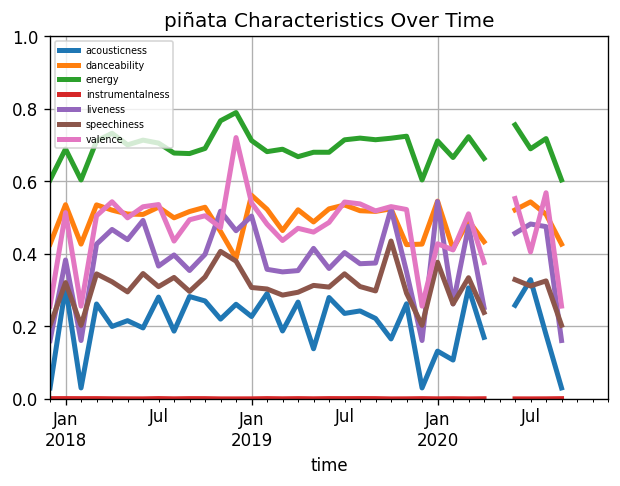

In [8]:
filtered_album = scrobbles[scrobbles["album"].str.lower() == album_name]
# select only descriptor float columns
filtered_album = filtered_album.loc[:, float_headers]
# resample by day and mean
filtered_album = filtered_album.resample("1M").mean()

# filtered_album["energy"].plot()
filtered_album.plot(lw=3)

plt.title(f"{album_name} Characteristics Over Time")
plt.legend(loc = "upper left", fontsize = "xx-small")
plt.ylim([0, 1])
plt.grid()
plt.show()

# Album Listening Time

In [9]:
limit = 50
albums = fmnet.top_albums(period=fmnet.Range.OVERALL, limit=limit)

filtered_albums = [scrobbles[scrobbles["album"] == i.name] for i in albums]

### STATS ###
# total time listening to artists 
albums_time = [i["duration_ms"].sum() for i in filtered_albums]
# total number of tracks
albums_track_count = np.array([i.drop_duplicates(["uri"]).count()[0] for i in filtered_albums])
# average length of artist's tracks (ms)
albums_average_track_length = np.array([i.drop_duplicates(["uri"])["duration_ms"].mean() for i in filtered_albums])

fig_size = (7,(5/20)*limit)

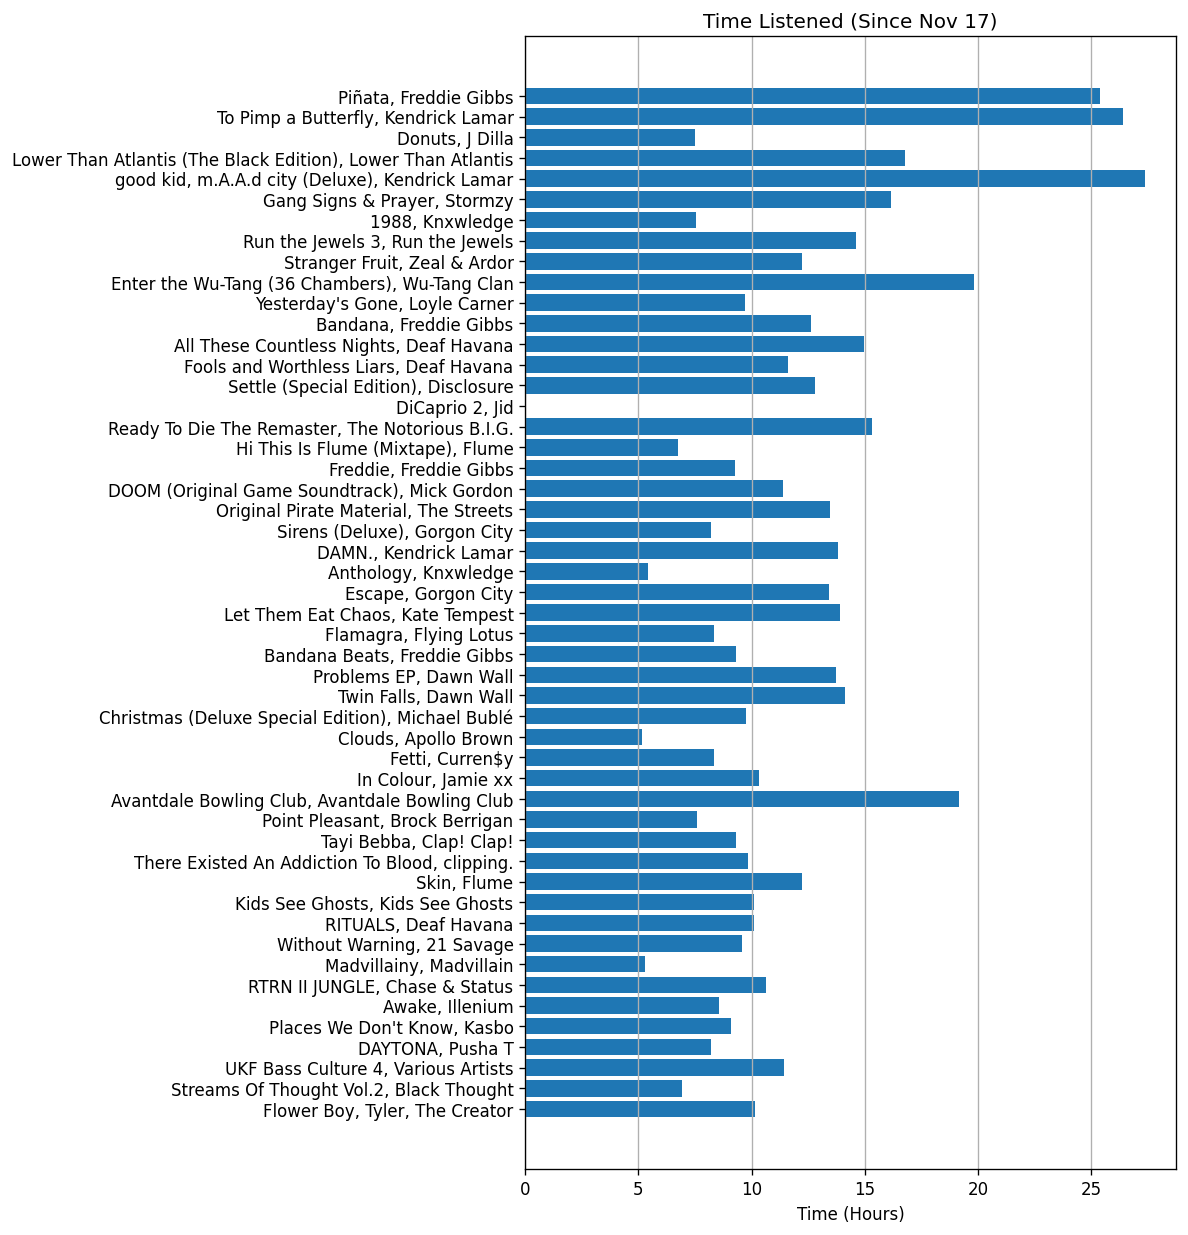

In [10]:
plt.figure(figsize=fig_size)
plt.barh(np.arange(len(albums))[::-1], np.array(albums_time) / (1000 * 60 * 60) )
plt.yticks(np.arange(len(albums))[::-1], labels=[f'{i.name}, {i.artist["name"]}' for i in albums])
plt.xlabel("Time (Hours)")
plt.grid(axis="x")
plt.title("Time Listened (Since Nov 17)")
plt.show()

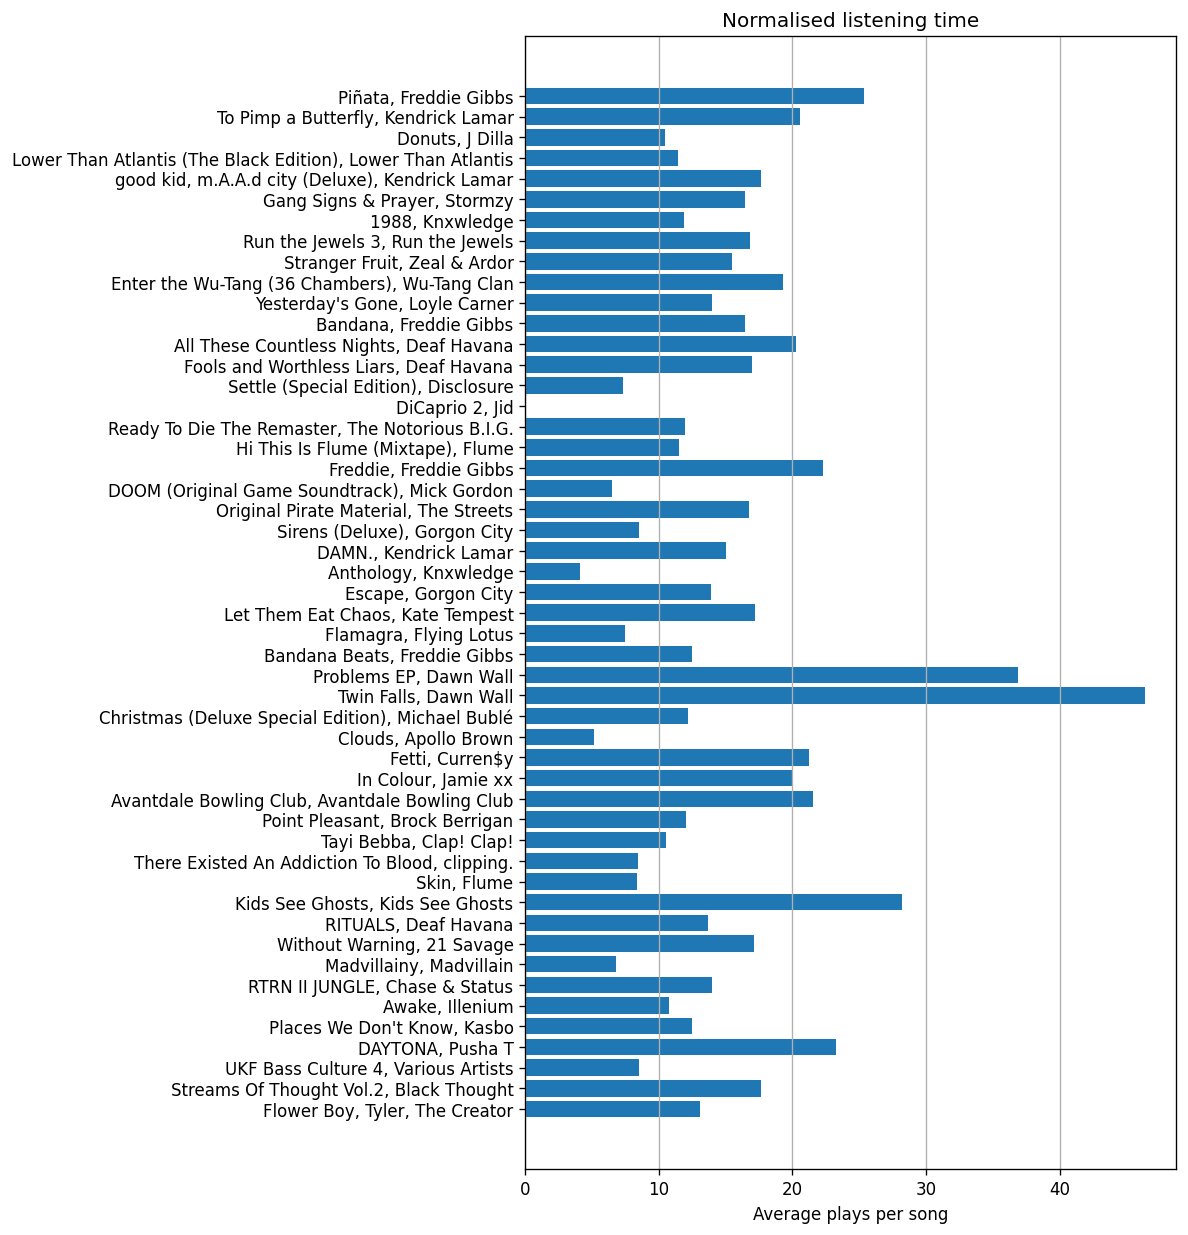

In [11]:
plt.figure(figsize=fig_size)
plt.barh(np.arange(len(albums))[::-1], np.array(albums_time) / (albums_track_count * albums_average_track_length) )
plt.yticks(np.arange(len(albums))[::-1], labels=[f'{i.name}, {i.artist["name"]}' for i in albums])
plt.xlabel("Average plays per song")
plt.grid(axis="x")
plt.title("Normalised listening time")
plt.show()

# Imports & Setup

In [1]:
from datetime import datetime

from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

from analysis.net import get_spotnet, get_fmnet, get_playlist, track_frame
from analysis.query import *
from analysis import float_headers, days_since

import pandas as pd
import numpy as np

client = bigquery.Client()
spotnet = get_spotnet()
fmnet = get_fmnet()
cache = 'query.csv'
first_day = datetime(year=2017, month=11, day=3)

## Read Scrobble Frame

In [3]:
scrobbles = get_query(cache=cache)

query.csv not found, pulling


## Write Scrobble Frame

In [4]:
scrobbles.reset_index().to_csv(cache, sep='\t')